## Model prediction: house pricing in California

Prediction notebook for housing price in California, EEUU. Data based on the book Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow.

### Data preparation

In [1]:
import os
import tarfile
import urllib
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

In [2]:
DOWNLOAD_ROOT = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/'
HOUSING_PATH = 'datasets/housing/'
HOUSING_URL = DOWNLOAD_ROOT + 'datasets/housing/housing.tgz'

In [3]:
HOUSING_URL

'https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.tgz'

In [4]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    '''Gets the data for the model'''
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [5]:
def load_housing_data(housing_path=HOUSING_PATH):
    '''Loads the data'''
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)

In [6]:
def split_train_test(data, test_ratio):
    '''Separates the data for train and test purpose'''
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]

    return data.iloc[train_indices], data.iloc[test_indices]

In [7]:
fetch_housing_data()
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [8]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [9]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


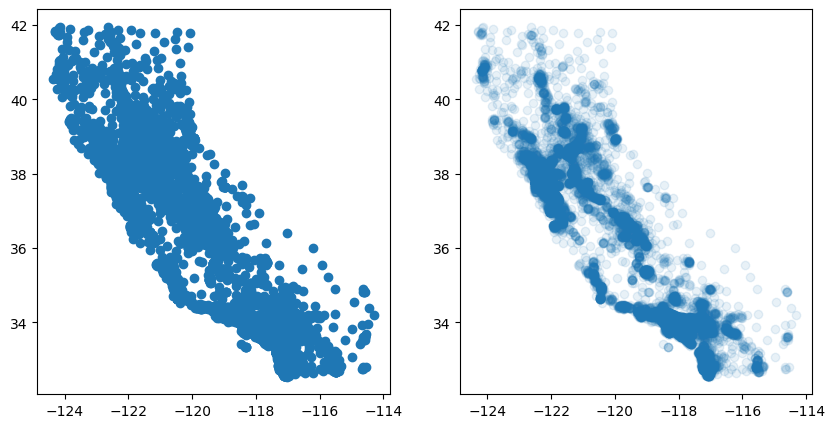

In [10]:
# Plot data using longitude and latitude
# with alpha = 0.1 we can see where there is a higher density of points

fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

data1=np.array(housing['longitude'])
data2=np.array(housing['latitude'])

ax1.scatter(data1,data2)
ax2.scatter(data1,data2, alpha=0.1)

#ax1 = housing.plot(kind='scatter', x='longitude', y='latitude')
#ax2 = housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)

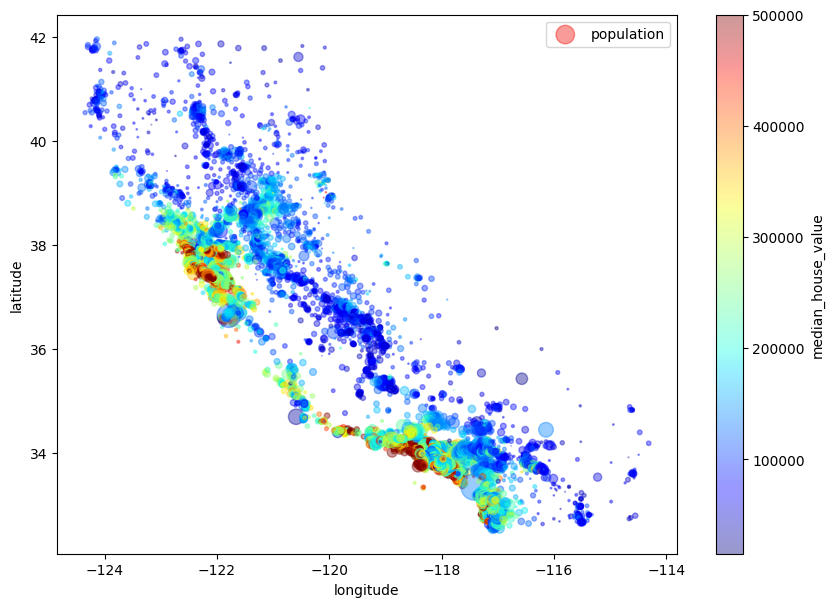

In [11]:
# plot house prices using colormap. Blue are lower values and red higher values.
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,
            s=housing['population']/100, label='population', figsize=(10,7),
            c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True)

plt.legend()

### Train the model

In [12]:
train_set, test_set = split_train_test(housing, 0.2)

In [13]:
categorical = ['ocean_proximity']
numerical = ['median_income']

In [14]:
dv = DictVectorizer()

In [15]:
train_dicts = train_set[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = test_set[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [16]:
target = 'median_house_value'
y_train = train_set[target].values
y_val = test_set[target].values

In [17]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

72786.92781821107

### Save the model

In [18]:
if os.path.isdir('models'):
    with open('models/lin_reg.bin', 'wb') as f_out:
        pickle.dump((dv, lr), f_out)
else:
    os.mkdir('models')
    print(f"Directory created successfully.")
    with open('models/lin_reg.bin', 'wb') as f_out:
        pickle.dump((dv, lr), f_out)

In [26]:
# Save the split data for experimentation and model registry
data_to_save = {
    'X_train': X_train,
    'X_val': X_val,
    'y_train': y_train,
    'y_val': y_val
}

with open('datasets/housing/split_data.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)